In [5]:
import os
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

rootPath = './datas/dogcat/'

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2, 1.0],
    horizontal_flip = True,
    validation_split = 0.2, #divides the set to 80% training, 20% validation
    fill_mode = 'nearest'
)

set_batch_size = 256

#80% training
trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'), #path to data folder
    target_size=(128, 128), #chagne the size to 128 128
    batch_size = set_batch_size, #batchsize 256
    class_mode='binary',  #picks the two folders cat and dogs and names them 0 and 1
    subset='training' #training
)

#20% validation
#same as above
validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(128,128),
    batch_size=set_batch_size,
    class_mode='binary', 
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


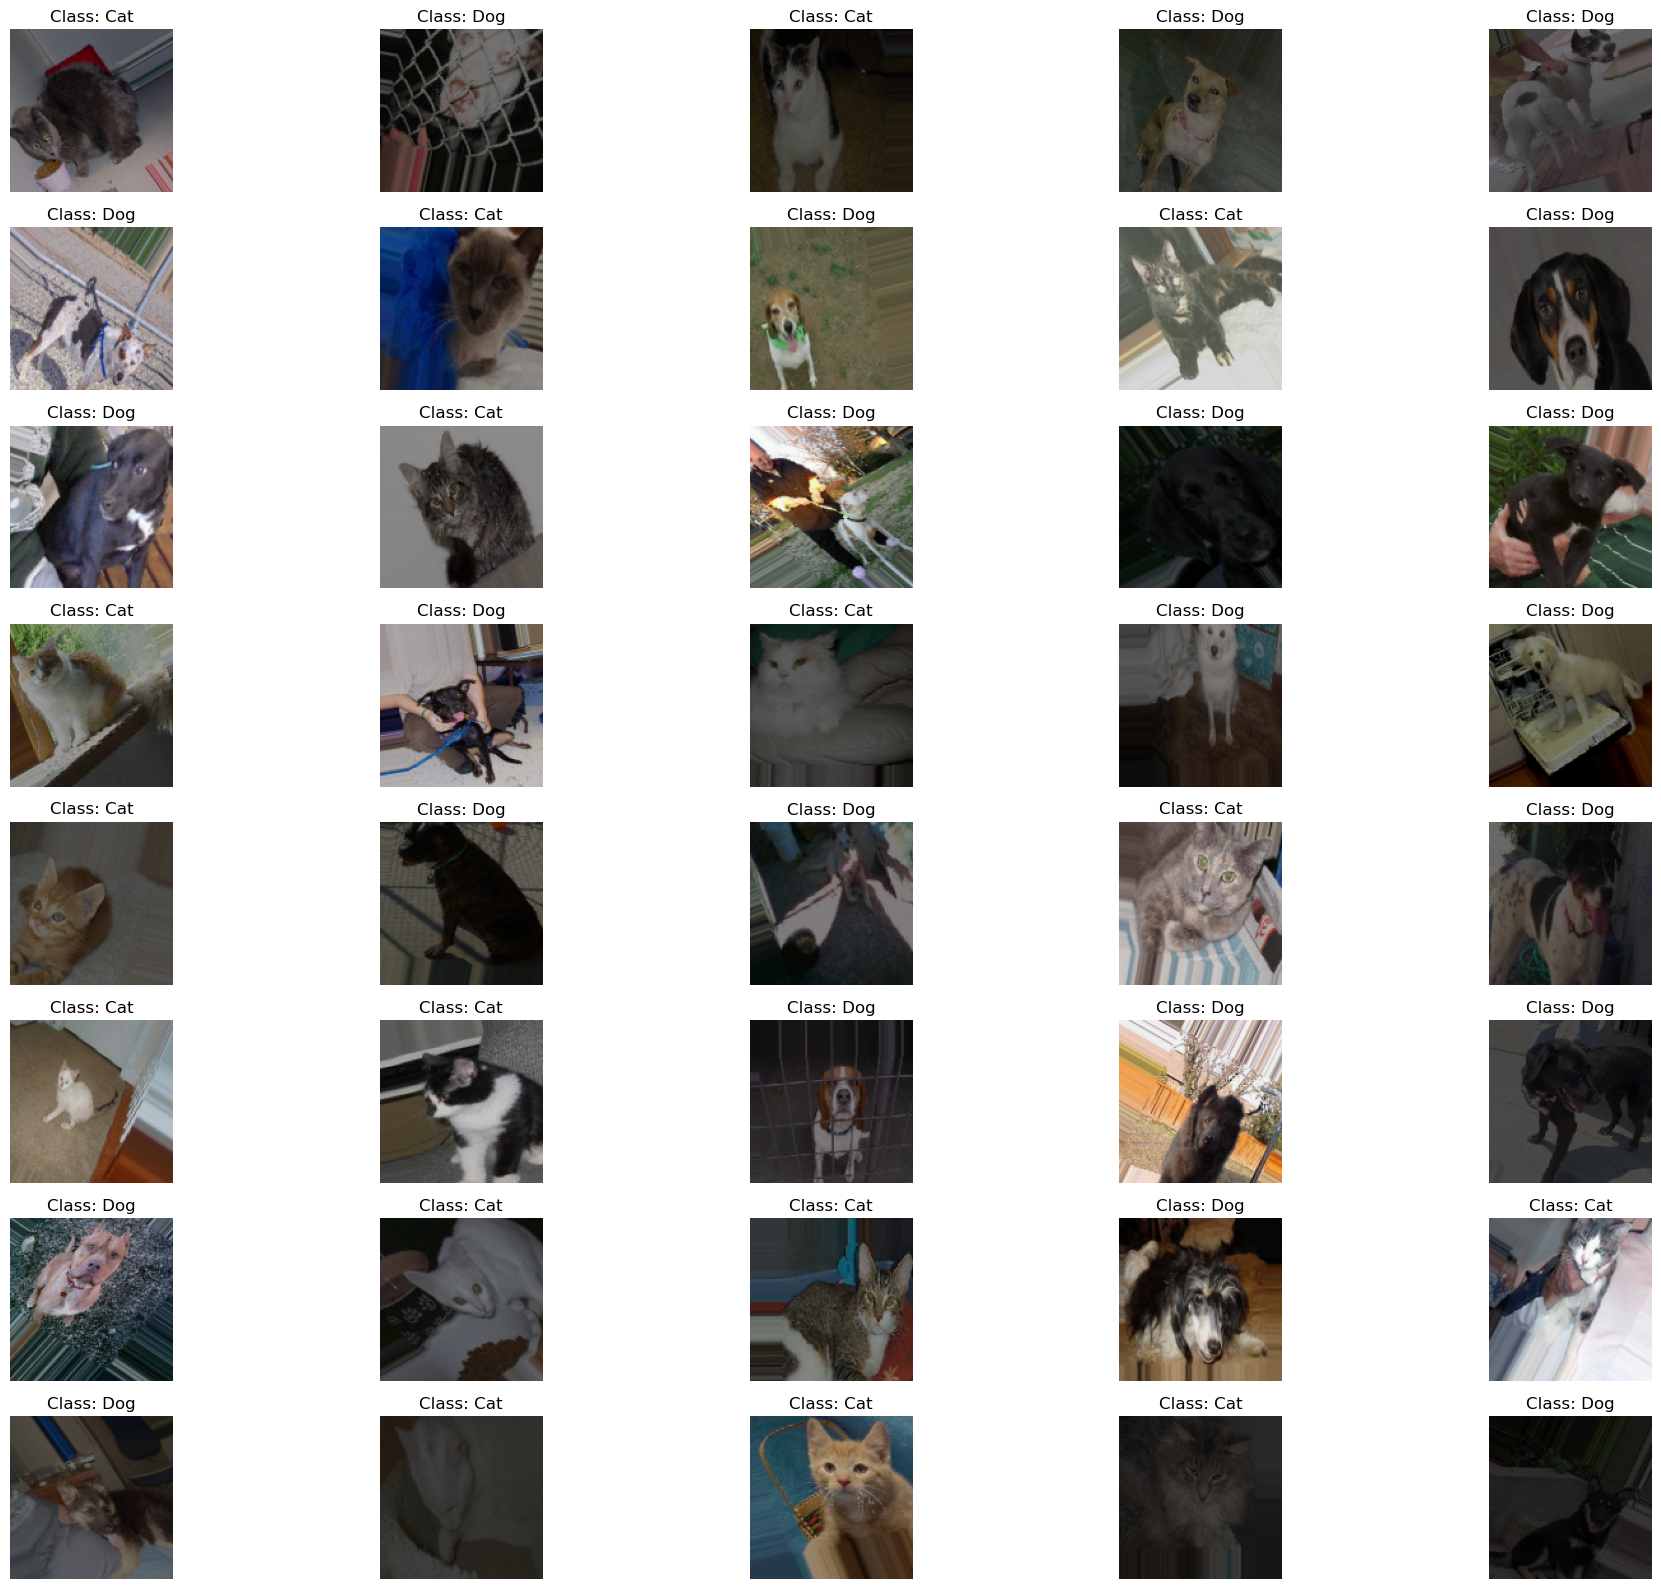

In [11]:
import numpy as np
import matplotlib.pyplot as plt

batch = next(trainGen)
images, labels = batch[0], batch[1]

random_indices = np.random.choice(len(images), 40, replace = False)

fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 16))
axes = axes.flatten()

for ax, idx in zip(axes, random_indices):
    img = images[idx]
    label = labels[idx]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class: {'Cat' if label == 0 else 'Dog'}")

plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input

model = Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

MODEL_DIR = './model/dogcat/dataext/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/dogcat/dataext/{epoch:02d}-{val_loss:.4f}.keras"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose=1, save_best_only=False)
early_stopping_callback = EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

epochs = 128
history=model.fit(
    trainGen, 
    epochs=epochs, 
    steps_per_epoch = trainGen.samples // trainGen.batch_size,
    validation_steps = validationGen.samples // validationGen.batch_size,
    validation_data = validationGen,
    callbacks = [checkpointer, early_stopping_callback, reduce_lr]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5126 - loss: 0.6924
Epoch 1: saving model to ./model/dogcat/dataext/01-0.6880.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - accuracy: 0.5128 - loss: 0.6924 - val_accuracy: 0.5440 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 2/128
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.5391 - loss: 0.6877

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to ./model/dogcat/dataext/02-0.6875.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 714ms/step - accuracy: 0.5391 - loss: 0.6877 - val_accuracy: 0.5903 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 3/128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5566 - loss: 0.6873
Epoch 3: saving model to ./model/dogcat/dataext/03-0.6731.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.5566 - loss: 0.6872 - val_accuracy: 0.5927 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 4/128
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:47 5s/step - accuracy: 0.5430 - loss: 0.6844
Epoch 4: saving model to ./model/dogcat/dataext/04-0.6821.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 599ms/step - accuracy: 0.5430 - loss: 0.6844 - val_accuracy: 0.5580 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 5/128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5730 - loss: 0.6770
Epoch 5: saving model to ./model/dogcat/dataext/05-0.6714.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0

KeyboardInterrupt: 

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16, 1))

plt.subplot(121)
plt.subplots_adjust(top=2)
plt.plot(epochs, accuracy, 'ro', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Loss')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox = True, shadow=True, ncol=5)
plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1),
           fancybox = True, shadow=True, ncol=5)
plt.show()